In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.manifold import TSNE
from sklearn import datasets

# t-distributed stochastic neighbor embedding (t-SNE)

## Podstawowe informacje:

- Metoda wizualizacji i eksploracji danych, najczęściej w dwu- lub trójwymiarze
- Rozwinięcie metody Stochastic neighbor embedding Roweisa i Hintona z 2002 roku 
- Została opracowana w 2008 roku przez Maatensa Hintona 
- Metoda nieliniowa i nienadzorowana

## Ogólna idea:

Algorytm t-SNE tworzy dyskretną miarę prawdopodobieństwa na parach punktów orginalnej przestrzeni, która odzwierciedla podobieństwo między tymi punktami. Następnie przenosi punkty do przestrzeni mniej wymiarowej i tworzy w niej analogiczną miarę podobieństwa, by oddać zależności między punktami istniejące w oryginalnej przestrzeni.

Dzięki temu możemy ocenić, jak bardzo sklastrowane są dane. Niestety metoda ta przez brak jawnej funkcji grupującej nadaje sie wyłącznie do eksploracji.

Scharakteryzujemy algorytm w trzech krokach:

## Krok 1: Wyznaczanie miary podobieństwa w pierwotnej przestrzeni

Nasz dane:

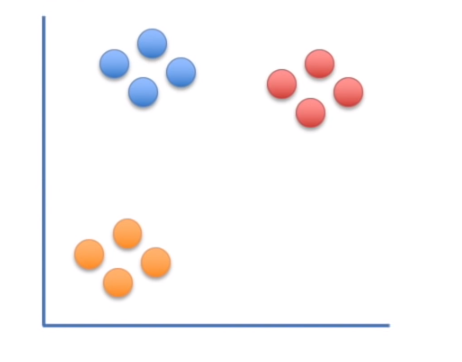

Tworzymy miarę prawdopodobieństwa na parach punktów o własności, że czym bliżej siebie się one znajdują, tym większa masa w tym punkcie. 

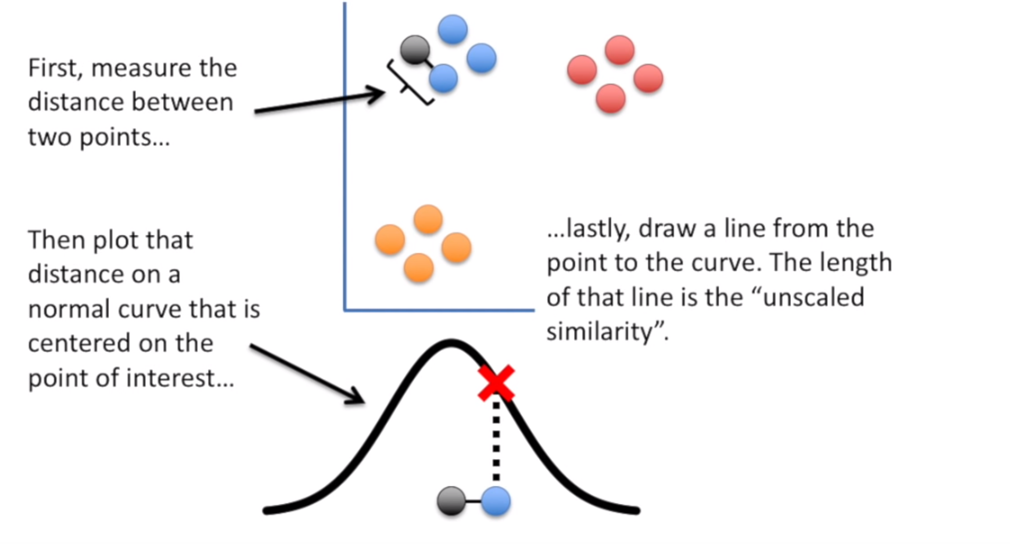

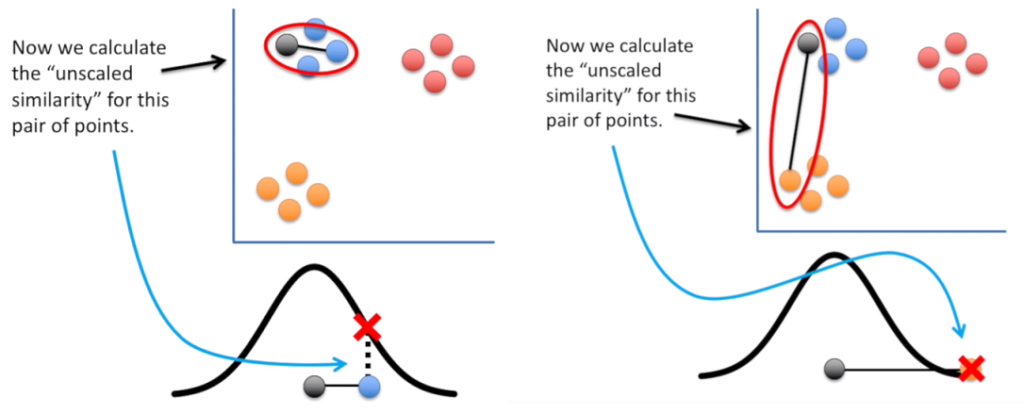

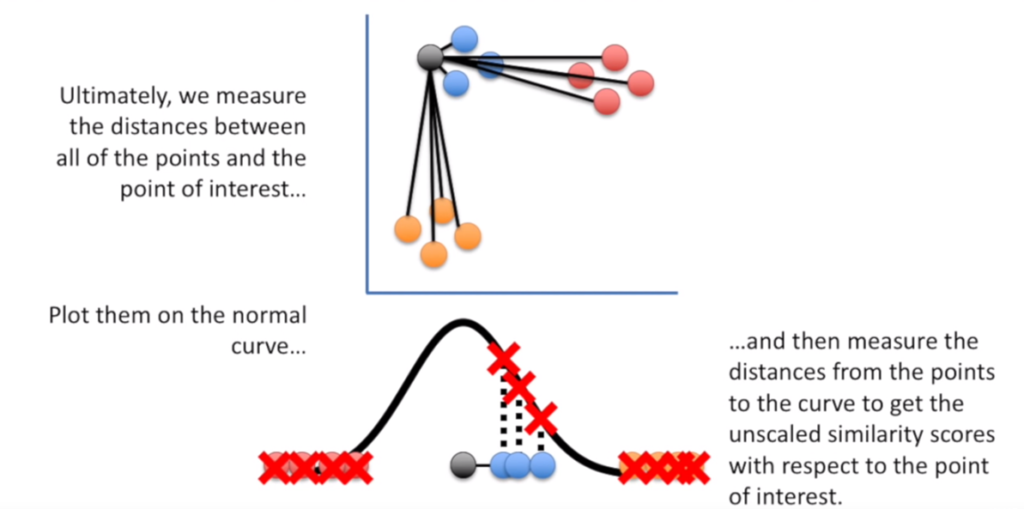

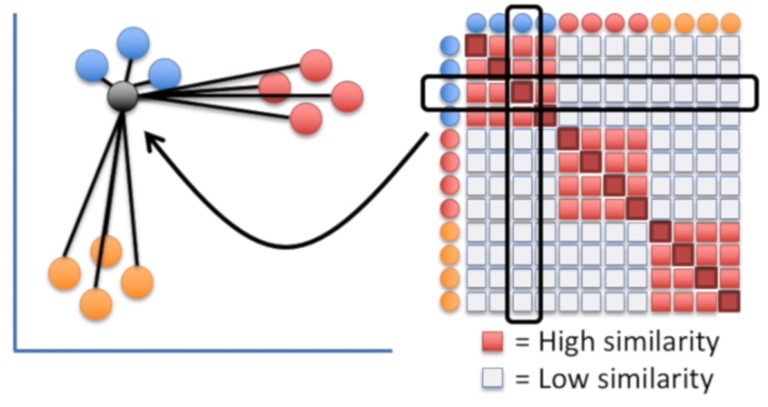

Formalnie:
    
Dla $i\neq j$ definiujemy:    $$ p_{j|i} = \frac{exp(-\parallel x_i-x_j \parallel ^2/2\sigma_i^2)}{\sum_{k \neq i}exp(-\parallel x_i-x_j\parallel ^2/2\sigma_i^2)} $$,     $p_{i|i}=0$ 

Następnie definiujemy:  $p_{ij}=\frac{p_{i|j}+p_{j|i}}{2N}$, gdzie $N$ to liczba punktów.

Zauważmy, że: $p_{ij}=p_{ji}$, $p_{ii}=0, \sum_{i,j}p_{ij}=1$

Warto zauważyć, że domyślną miarą odległości punktów $\parallel * \parallel$, z której korzystamy jest ogległość Euklidesowa, ale równie dobrze może być to inna miara odległości (parametr $metric$). 

Parametr $\sigma_i$ są dobierane tak, by $perplexity$ miary $p_{ij}$ było równe z góry zadanemu. $Perplexity$ miary prawdopodobieństwa $p$:
$$PP(p):= 2^{H(p)}=2^{-\sum_x p(x)log_2p(x)} $$. Prowadzi to do dopasowania parametrów $\sigma_i$ do lokalnej gęstości danych: czym gęściej wokół punktu $x_i$, tym mniejsze $\sigma_i$, co jest bardzo pożądane.

##  Krok 2: Rzutowanie przestrzeni na mniejszą i wyznaczanie na niej miary podobieństwa

Wizualizacja kroku w przypadku rzutowania na prostą - przestrzeń jednowymiarową:

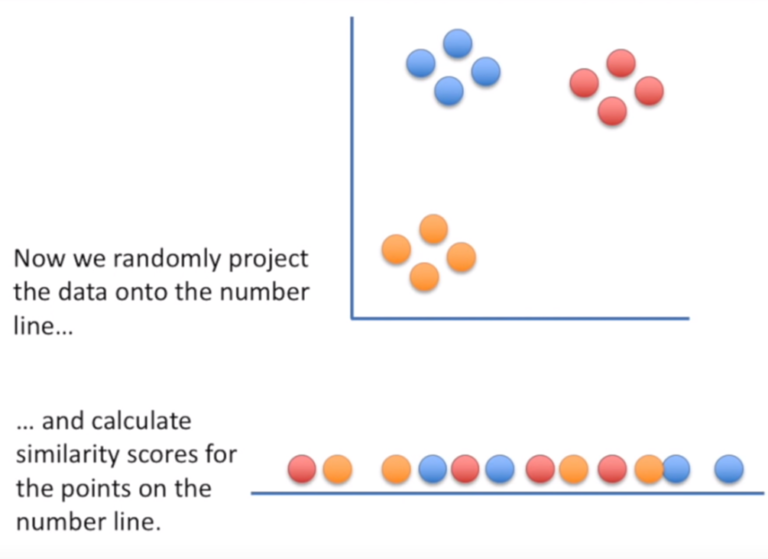

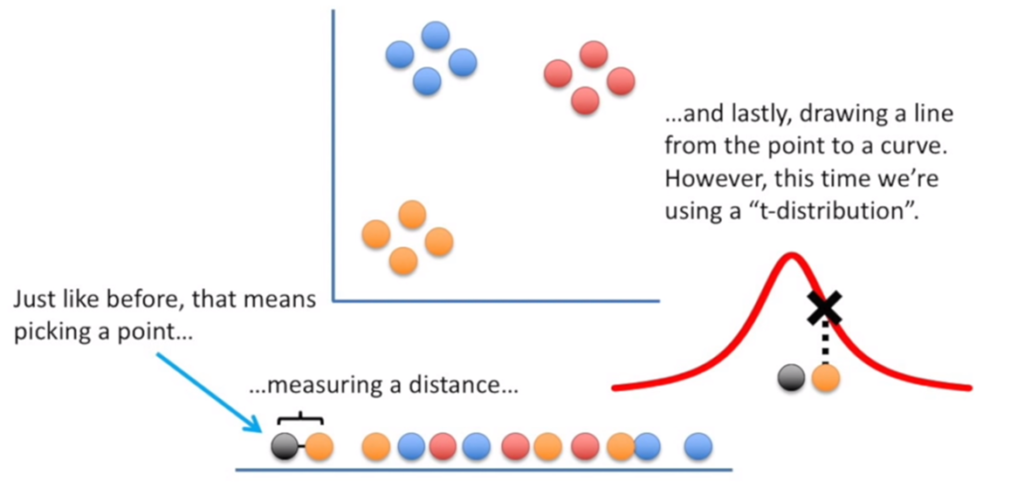

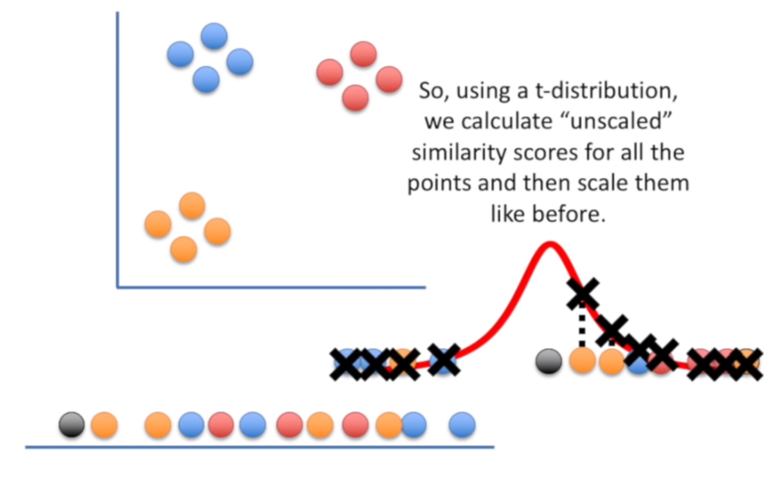

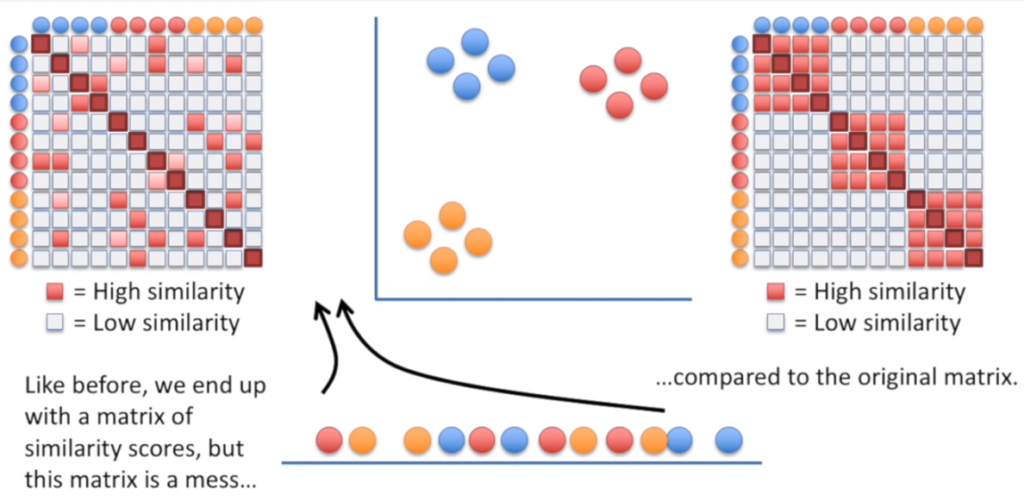

Formalnie tworzymy miarę prawdopodobieństwa na parach punktów, tym razem korzystając z rozkładu t-Studenta z jednym stopniem swobody (rozkład Cauchy'ego):

Gdy $i\neq j$, to $q_{ij}=\frac{(1+\parallel y_i-y_j\parallel^2)^{-1}}{\sum _k\sum_{l\neq k}(1+\parallel y_k-y_l\parallel^2)^{-1}}$,  $q_{ii}=0$

Zamiast rzutować punkty losowo na początku tego kroku, możemy zrzutować je na przykład metodą $PCA$ (parametr $init$).

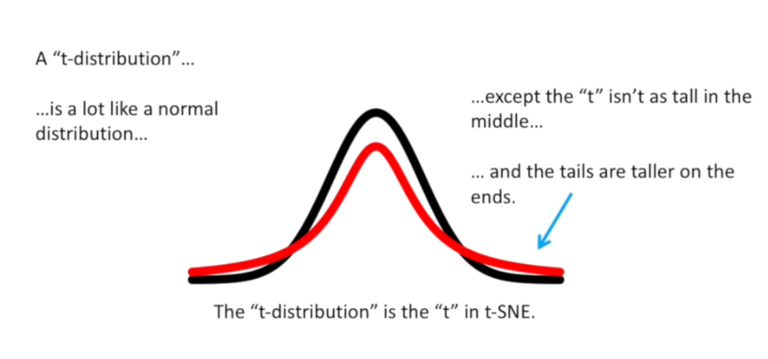

Powodem dla którego używamy rozkładu t-Studenta jest to, by punkty, które były niepodobne do siebie w oryginalnej przestrzeni znalazły się jak najdalej w przestrzeni niskowymiarowej.  

## Krok 3: Upodabnianie miary $q_{ij}$ do miary $p_{ij}$

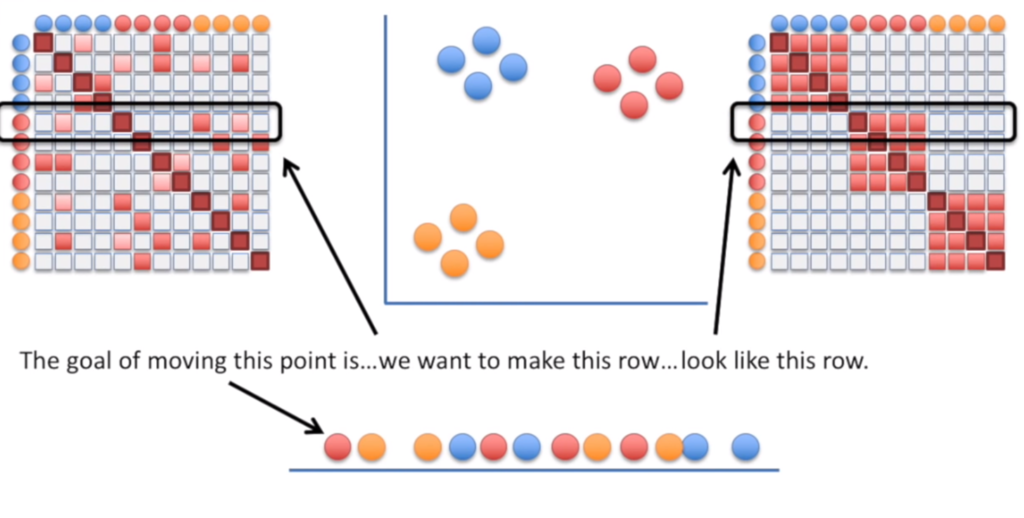

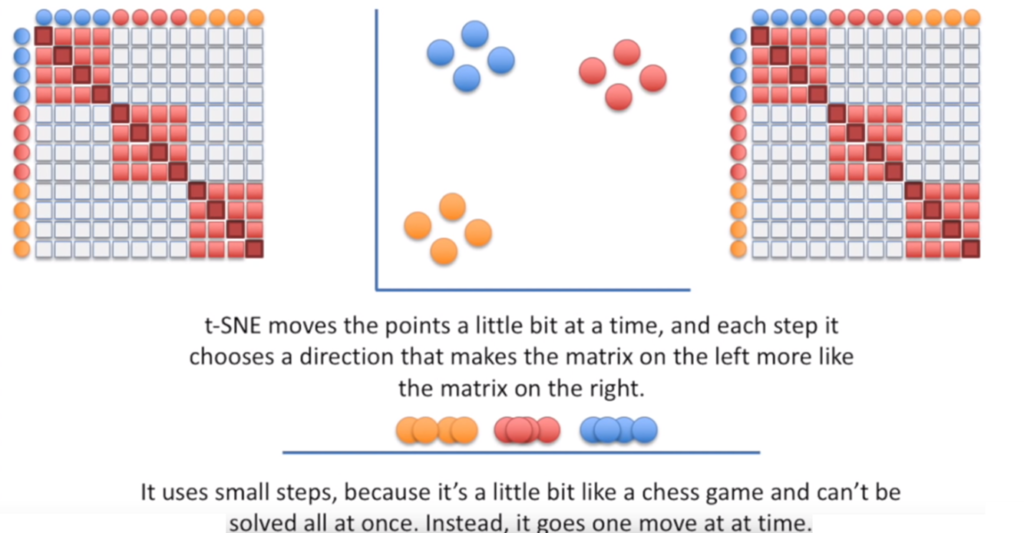

Formalnie chcemy minimalizować funkcję różności naszych dwóch miar. Za tą funkcję przyjmujemy dywergencję Kullbacka-Leiblera (entropię względną) opisaną wzorem: $$KL(P\parallel Q)= \sum_{i\neq j}p_{ij}log\frac{p_{ij}}{q_{ij}}$$

Dokonujemy tego, za pomocą metody gradientu prostego (znajdujemy gradient fukcji i przesuwany argument w kierunku przeciwnym do gradientu, gdzie znajduje się maksimum lokalne $x_{k+1}=x_k-\alpha_k \nabla f(x_k)$)

Bardzo ważne jest to, że funkcja entropii względnej nie jest funkcją wypukłą ani wklęsłą, przez co może mieć ona wiele lokalnych maksimów. Z tego względu wynik działania algorytmu $t-SNE$ za każdym razem może być inny, zależnie od miejsca, w którym zaczniemy minimalizować funkcje KL, czyli od tego jak zrzutujemy punkty. Zrzutowanie metodą $PCA$ jest stabilniejsze globalnie niż zrzutowanie losowe. 

## Zalety

- t-SNE jest metodą nieliniową, przez co potrafi wykryć złożone wielomianowe zależności w danych
- w wielu praktycznych zastosowaniach t-SNE okazuje się bardzo skuteczny, przez co zyskał popularność

## Wady 
- t-SNE jest algorytmem probablistycznym, przez co daje różne wyniki działania pomimo jednakowych parametrów
- w odróżnieniu od części metod redukcji wymiarowości nie może być on prosto używany do predykcji, bo nie da się wyznaczyć funkcji odwrotnej tego przekształcenia
- jest drogi obliczeniowo 

## Uwagi na temat parametrów sklearn.manifold.TSNE

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

- n_components (default: 2): wymiar przestrzeniu, na którą rzutujemy
- perplexity  (default: 30): parametr lepiej opisany w kroku pierwszym, można go traktować analogicznie do liczby sąsiadów w innych algorytmach, zwykle stosuje sie wielkości od 5 do 50
- metric (default: 'euclidean'): miara odległości punktów
- init (default: 'random'): metoda rzutowania puntów z kroku 2, domyślnie losowa, ale można ustawić 'pca'
- random_state (default: None): ustawienie ziarna, by umożliwić powtarzalność wyniku
- n_iter, n_iter_without_progress, min_grad_norm: parametry mogące przyspieszyć działanie algorytmu związane z krokiem 3


## Przykłady

Rozmiar danych (shape): (5000, 3)


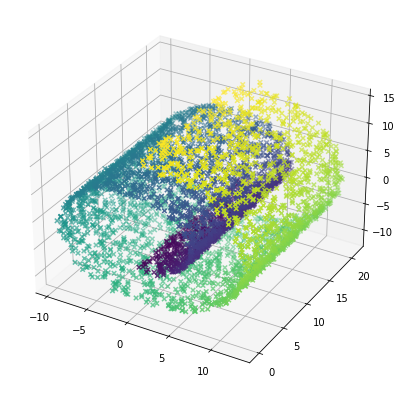

In [8]:
swissroll, color = datasets.make_swiss_roll(n_samples=5000, noise=0.1, random_state=42)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
 
print(f'Rozmiar danych (shape): {swissroll.shape}')
ax.scatter(swissroll[:,0], swissroll[:,1], swissroll[:,2], marker='x', c=color);

Perplexity = 5
14.718706369400024


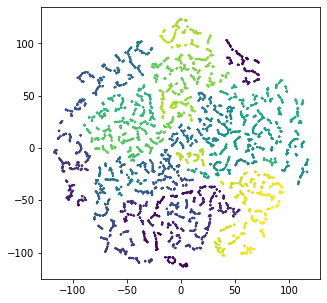

Perplexity = 10
15.323321104049683


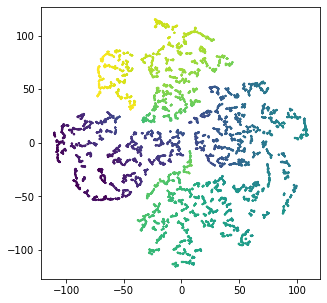

Perplexity = 30
28.76720118522644


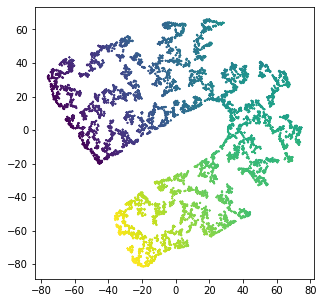

Perplexity = 50
25.375499725341797


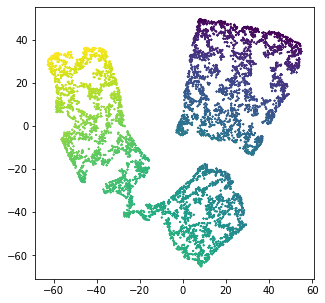

In [17]:
for perplexity in [5, 10, 30, 50]:
    print(f'Perplexity = {perplexity}')
    start = time.time()
    X_tsne = TSNE(perplexity=perplexity).fit_transform(swissroll)
    end = time.time()
    print(end-start)
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, marker="x", s=2)
    plt.show();

## Mnist małowymiarowy 8x8

Perplexity = 30
12.34229564666748


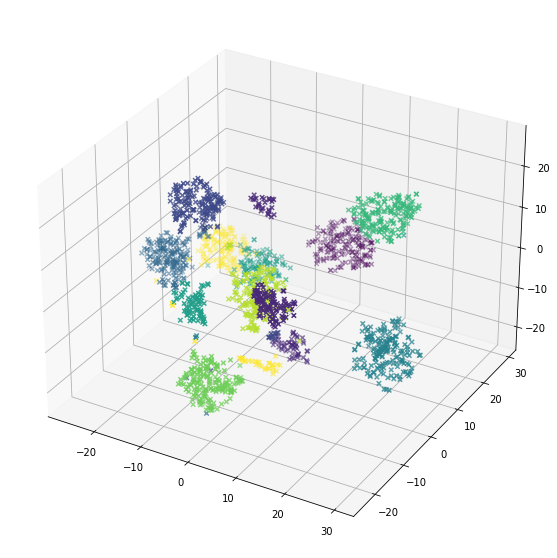

In [19]:
data = datasets.load_digits()

Y = data['target']
X = data['data']

for perplexity in [30]:
    print(f'Perplexity = {perplexity}')
    start = time.time()
    X_tsne = TSNE(3,perplexity=perplexity,init='pca').fit_transform(X)
    end = time.time()
    print(end-start)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:,2], c=Y, marker="x")
    plt.show();

Perplexity = 30
5.909470558166504


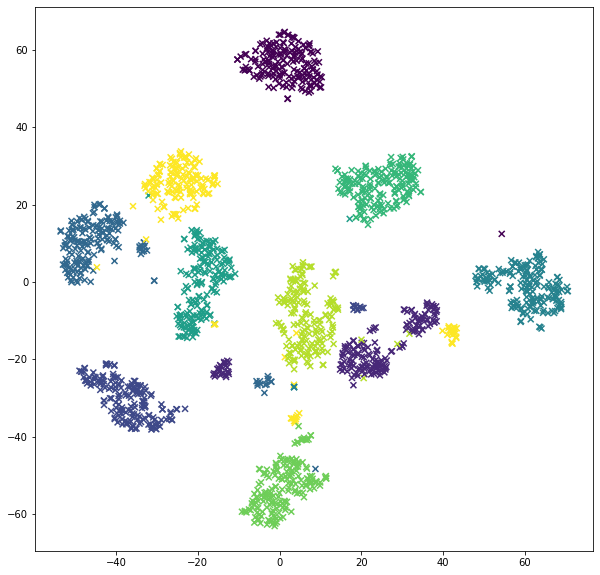

In [23]:
data = datasets.load_digits()

Y = data['target']
X = data['data']

for perplexity in [30]:
    print(f'Perplexity = {perplexity}')
    start = time.time()
    X_tsne = TSNE(perplexity=perplexity,init='pca').fit_transform(X)
    end = time.time()
    print(end-start)
    fig = plt.figure(figsize=(10,10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, marker="x")
    plt.show();

Perplexity = 30
6.304057836532593


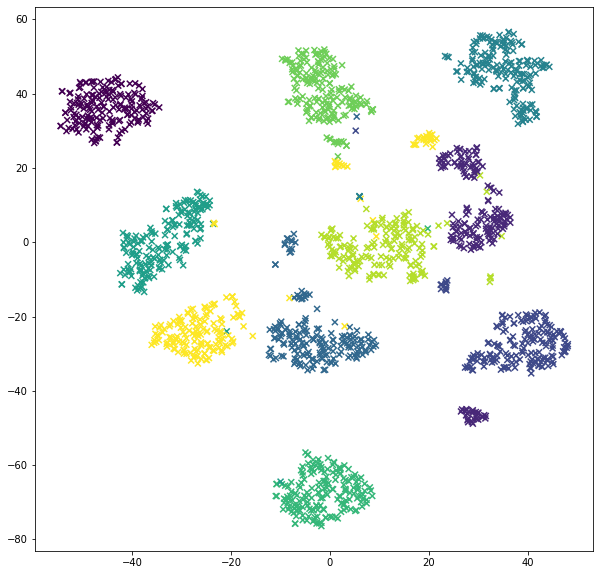

In [24]:
data = datasets.load_digits()

Y = data['target']
X = data['data']

for perplexity in [30]:
    print(f'Perplexity = {perplexity}')
    start = time.time()
    X_tsne = TSNE(perplexity=perplexity).fit_transform(X)
    end = time.time()
    print(end-start)
    fig = plt.figure(figsize=(10,10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, marker="x")
    plt.show();

## Mnist wysokowymiarowy 28x28

In [22]:
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

Downloading...
From: https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU
To: /home/lukas/Jupyter/mnist.npz
55.4MB [00:23, 2.31MB/s]


Perplexity = 5
14.082376718521118


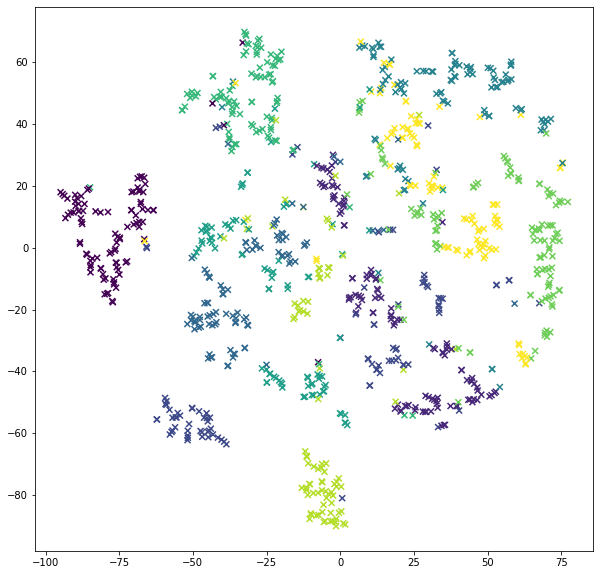

Perplexity = 10
10.621585845947266


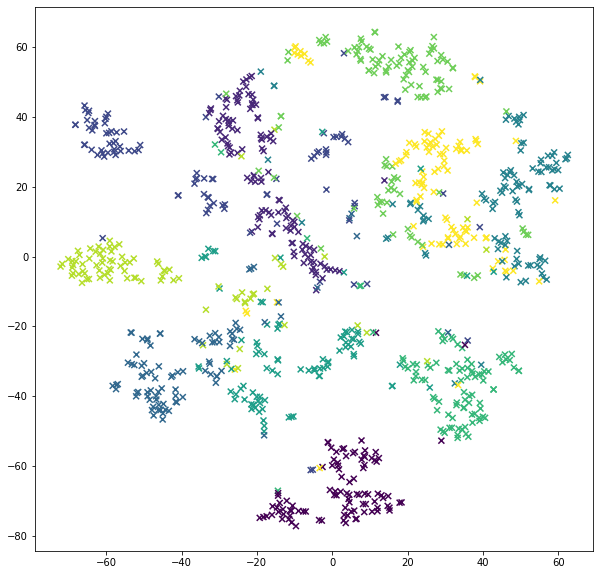

Perplexity = 30
20.42815899848938


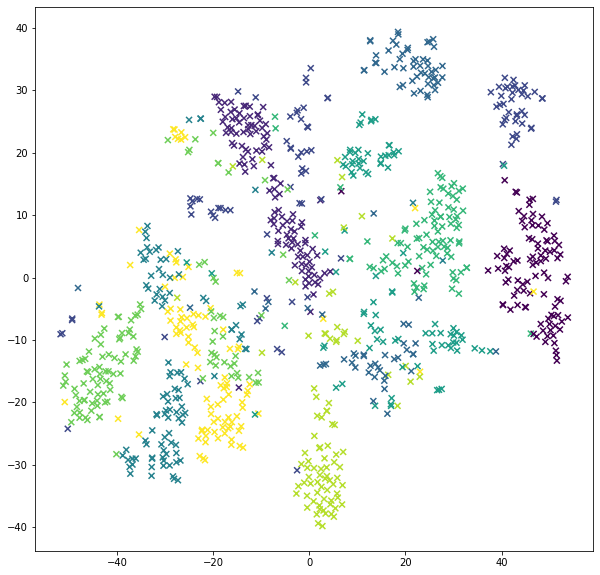

Perplexity = 50
20.884176015853882


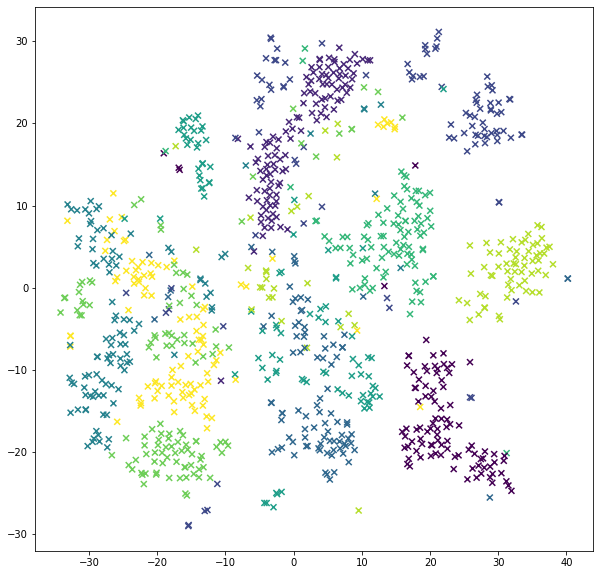

In [8]:
with np.load('mnist.npz') as data:
    train_data = data['train_data']
    train_labels = data['train_labels']
    
Y = train_labels[:1000]
X = train_data.reshape(-1,28*28)[:1000]

for perplexity in [5, 10, 30, 50]:
    print(f'Perplexity = {perplexity}')
    start = time.time()
    X_tsne = TSNE(perplexity=perplexity).fit_transform(X)
    end = time.time()
    print(end-start)
    fig = plt.figure(figsize=(10,10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, marker="x")
    plt.show();

Perplexity = 5
13.67545771598816


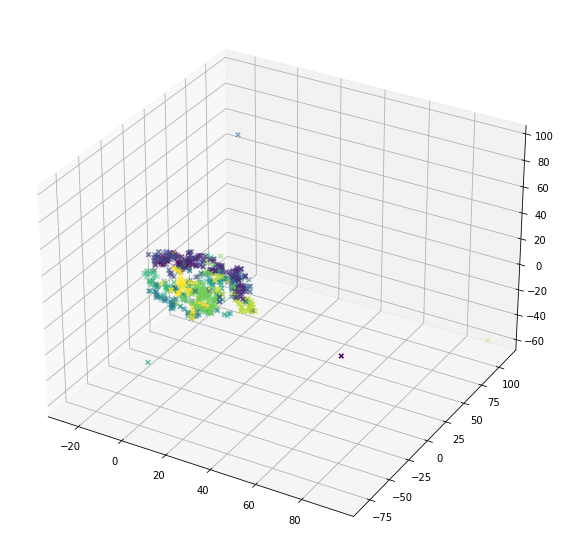

Perplexity = 10
14.099189281463623


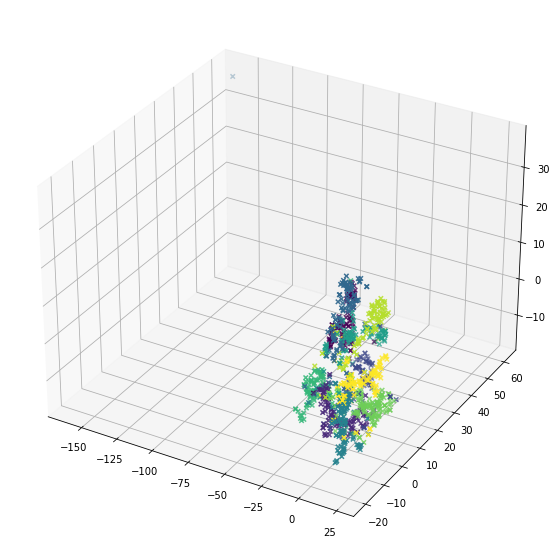

Perplexity = 30
12.468311071395874


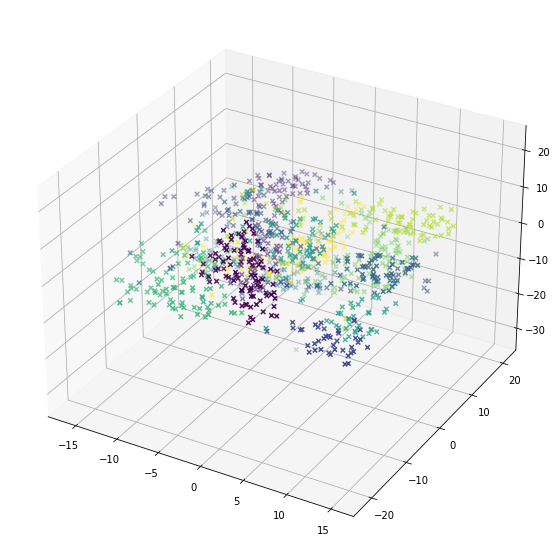

Perplexity = 50
13.30260443687439


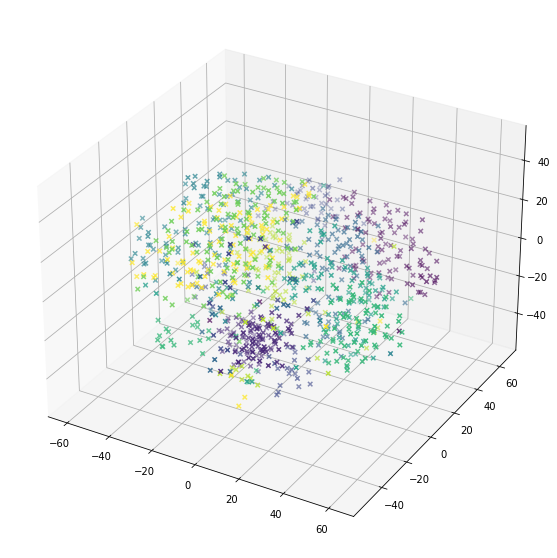

In [6]:
with np.load('mnist.npz') as data:
    train_data = data['train_data']
    train_labels = data['train_labels']
    
Y = train_labels[:1000]
X = train_data.reshape(-1,28*28)[:1000]

for perplexity in [5, 10, 30, 50]:
    print(f'Perplexity = {perplexity}')
    start = time.time()
    X_tsne = TSNE(3,perplexity=perplexity).fit_transform(X)
    end = time.time()
    print(end-start)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:,2], c=Y, marker="x")
    plt.show();

Perplexity = 30
12.334628343582153


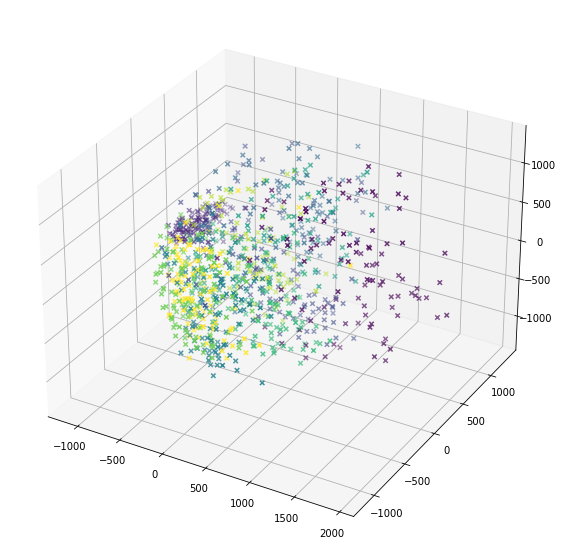

In [21]:
with np.load('mnist.npz') as data:
    train_data = data['train_data']
    train_labels = data['train_labels']
    
Y = train_labels[:1000]
X = train_data.reshape(-1,28*28)[:1000]

for perplexity in [30]:
    print(f'Perplexity = {perplexity}')
    start = time.time()
    X_tsne = TSNE(3,perplexity=perplexity,init='pca').fit_transform(X)
    end = time.time()
    print(end-start)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:,2], c=Y, marker="x")
    plt.show();